# Feature Discovery & Extraction Experiement

The purpose of this experiement is to explore the URL dataset and attempt to find significant, useful features to attach to the dataset for training our ML models.

The 1st identified type of features that will be explored is Lexical-based features: These are based on characteristics of the makeup of the URL strings themselves.

Examples would be: 
- Length of URL
- How many sub-domains
- Length of Top Level Domain (TLD)
<br/>... etc

Firstly, the data for Benign and Malicious classed URLs will be joined into 1 dataset:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, plot_roc_curve, average_precision_score

from featureprocessing import FeatureEngineering as fe
from datacleaning import URLDataCleaning as ucl

from sklearn.datasets import load_iris

In [2]:
import pandas as pd

df_benign = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Benign_list_big_final.csv')
df_benign["URLType"] = "Benign"

df_malicious = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Malware_dataset.csv')
df_malicious["URLType"] = "Malicious"

dfs = [df_benign, df_malicious]
base_df = pd.concat(dfs)
base_df.reset_index(drop=True, inplace=True)
base_df = base_df.sample(frac=1).reset_index(drop=True)

display(base_df)

,URL,URLType
0,http://www.mt6669.com/cl/tpl/montecarlo/ver1/c...,Malicious
1,http://katproxy.com/desktop-wallpapers-erotic-...,Benign
2,http://themeforest.net/item/structure-construc...,Benign
3,http://rt.com/shows/redacted-tonight-summary/2...,Benign
4,http://torcache.net/torrent/48DC7BE19EBDE8F1E2...,Benign
...,...,...
46939,http://twitter.com/home?status=%E3%83%8C%E3%81...,Benign
46940,http://9779.info/%E5%89%AA%E8%B4%B4%E7%94%BB%E...,Malicious
46941,http://olx.pl/i2/elektronika/pozostala-elektro...,Benign
46942,http://metro.co.uk/2015/05/13/expect-norwich-c...,Benign


Next, the classes Benign/Malicious will be label encoded, prepping them so that they can be used by ML models:
- Benign | 0
- Malicious | 1

This will be saved as the base dataset that can be built upon with whatever features to be experimented with:

In [3]:
enc = preprocessing.LabelEncoder()
base_df["URLType"] = enc.fit_transform(base_df.URLType.values)
base_df.to_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/base_dataset.csv', index=False)

Below is a function defined to extract all of the lexical features that we want to experiment with. 

In [4]:
import urllib.parse
import whois
import re
from tld import get_tld, is_tld
from urllib.parse import urlparse

def clean_data(url):
    url_obj = urlparse(url)
    if not url_obj.scheme:
        url = "http://" + url
        return url
    return url

def lexical_extract(url):
    """
    Extract lexical based features from the URL strings in the dataset. These features include:
    - Length of URL
    - Length of Hostname
    - Path length
    - TLD Length
    - Special Char Count
    - '.-@%=?' Char Count
    - Digit Count
    - Unique Char Count"""

    if not url:
        return

    url_dt = {}

    url_len = len(url)
    url_dt.update({"URLLength": url_len})

    url_rg = '(?:http.*://)?(?P<host>[^:/ ]+).*'
    url_search = re.search(url_rg, url)
    host_len = len(url_search.group('host'))
    url_dt.update({"HostLength": host_len})

    parsed_tld = get_tld(url, fix_protocol=True, fail_silently=True)
    if parsed_tld is None:
        url_dt.update({"TLDLength": 0})
    else:
        tld_len = len(parsed_tld)
        url_dt.update({"TLDLength": tld_len})

    dot_count = str(url).count('.')
    url_dt.update({"DotCount": dot_count})

    dash_count = str(url).count('-')
    url_dt.update({"DashCount": dash_count})

    at_count = str(url).count('@')
    url_dt.update({"@Count": at_count})

    percent_count = str(url).count('%')
    url_dt.update({"%Count": percent_count})

    equals_count = str(url).count('=')
    url_dt.update({"=Count": equals_count})

    question_mark_count = str(url).count('?')
    url_dt.update({"?Count": question_mark_count})

    d_count = sum(list(map(lambda x:1 if x.isdigit() else 0, list(url))))
    url_dt.update({"DigitCount": d_count})

    un_ch_count = len(set(url))
    url_dt.update({"UniqueCharCount": un_ch_count})

    return url_dt

In [5]:
feature_list = []
for index, row in base_df.iterrows():
    row["URL"] = clean_data(row["URL"])
    feature_dict = lexical_extract(row["URL"])
    feature_dict.update({"URLType": row["URLType"]})
    feature_list.append(feature_dict)

features_df = pd.DataFrame(feature_list)
display(features_df)

features_df.to_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/feature_dataset.csv', index=False)

,URLLength,HostLength,TLDLength,DotCount,DashCount,@Count,%Count,=Count,?Count,DigitCount,UniqueCharCount,URLType
0,74,14,3,4,0,0,0,1,1,9,24,1
1,106,12,3,2,9,0,0,0,0,31,32,0
2,95,15,3,1,3,0,0,0,0,8,29,0
3,85,6,3,1,6,0,0,0,0,6,27,0
4,125,12,3,8,0,0,0,1,1,23,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46939,325,11,3,2,1,0,80,1,1,101,49,0
46940,81,9,4,1,0,0,21,0,0,27,19,1
46941,84,6,2,1,2,0,0,0,0,1,19,0
46942,127,11,5,2,17,0,0,0,0,15,33,0


Lets analyse the existing correlations/relationships that these engineered features have amoungest eachother

In order to ensure that meaningful & impactful features will be used by ML models, they will have to be analysed using statistical methods in order to find the features that have the biggest impact, and filter out any features that have either the same values across most if not all records, or have very little impact on the class.<br/><br/>
The dataset will be split into train & test sets for fitting to the feature selector:

## Feature Transformation

A scaler must be applied to the feature set in order to scale the data values for model ingestion. For initial models, we will use the MinMaxScaler transformer from sklearn. 

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

class LexicalFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=MinMaxScaler):
        self.scaler = scaler

    def fit(self, X, *_):
        self.scaler = self.scaler()
        self.scaler.fit(X)
        return self

    def transform(self, X, *_):
        scaled = self.scaler.transform(X)
        return scaled

In [11]:
from sklearn.model_selection import train_test_split

x = features_df.drop(['URLType'], axis=1)
y = features_df['URLType']

X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

scaler=LexicalFeatureScaler()
scaler.fit(X_train, Y_train)
X_train = scaler.transform(X_train)
x_test = scaler.transform(x_test)

## Base SVC Model

In [67]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, make_scorer

model = SVC()
cv = KFold(n_splits=10, shuffle=True, random_state=1)

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (tn/(tn+fp))
    return rate

def tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (tp/(tp+fn))
    return rate

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (fn/(fn+tp))
    return rate

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (fp/(fp+tn))
    return rate

scoring = {'tp': make_scorer(tp),
           'tn': make_scorer(tn),
           'fp': make_scorer(fp),
           'fn': make_scorer(fn),
           'tpr': make_scorer(tpr),
           'tnr': make_scorer(tnr),
           'fpr': make_scorer(fpr),
           'fnr': make_scorer(fnr),
}
scores = cross_validate(model, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1)
model.fit(X_train, Y_train)

def get_avg_stats(stat):
    total = 0
    for item in stat:
        total += item
    
    avg = (total/stat.size)
    return avg

print("TP: {}\nRate: {}\n\nTN: {}\nRate: {}\n\nFP: {}\nRate: {}\n\nFN: {}\nRate: {}\n".format(
    get_avg_stats(scores["test_tp"]),
    get_avg_stats(scores["test_tpr"]),
    get_avg_stats(scores["test_tn"]),
    get_avg_stats(scores["test_tnr"]),
    get_avg_stats(scores["test_fp"]),
    get_avg_stats(scores["test_fpr"]),
    get_avg_stats(scores["test_fn"]),
    get_avg_stats(scores["test_fnr"]),
))

TP: 683.7
Rate: 0.8796520605249579

TN: 2341.6
Rate: 0.9888896075467593

FP: 26.3
Rate: 0.011110392453240615

FN: 93.6
Rate: 0.12034793947504215



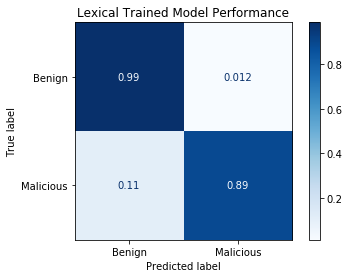

In [33]:
import matplotlib.pyplot as plt

y_pred=model.predict(x_test)

from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Lexical Trained Model Performance')
plt.show()

## Bayesian SVC Search Cross Validation

Now we will attempt to find the best optimised SVC model by performing a Bayesian Cross Validation search on a defined SVC hyperparameter search space:

In [18]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('model', SVC(probability=True))
])

svc_search = {
    'model': Categorical([SVC(probability=True)]),
    'model__C': Real(0.01, 100.0, 'log-uniform'),
    'model__kernel': Categorical(['poly', 'rbf']),
}

searchcv = BayesSearchCV(
    SVC(),
    search_spaces = {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'kernel': Categorical(['poly', 'rbf']),
    },
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

def on_step(optim_result):
    score = searchcv.best_score_
    print(f'Best score: {score}')
    if score >= 0.98:
        print('Interrupting!')
        return True
    
import time
start_time = time.time()

searchcv.fit(X_train, Y_train, callback=on_step)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.0min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.752861503243037
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.0min remaining:   40.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.752861503243037
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   58.5s remaining:   39.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.752861503243037
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   44.5s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.752861503243037
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   59.2s remaining:   39.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.752861503243037
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.2min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.1min remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   51.0s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   32.6s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.3s finished


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   45.8s remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.6s finished


Best score: 0.9751685107465344
--- 1254.051386833191 seconds ---


TPR: 0.9219615080411284
TNR: 0.991281306094538
FPR: 0.008718693905462005
FNR: 0.07803849195887161
Best params found: {'C': 70168.21694597807, 'gamma': 0.5659313404580029, 'kernel': 'rbf'}


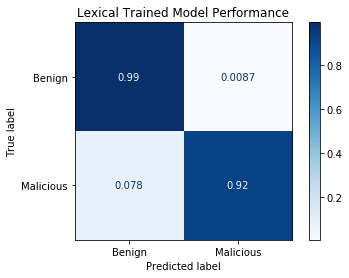

In [34]:
y_pred = searchcv.predict(x_test)
print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Best params found: {searchcv.best_params_}')

disp = plot_confusion_matrix(searchcv.best_estimator_, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Lexical Trained Model Performance')
plt.show()

Base model AUC: 0.9801911498020691
Optimised model AUC: 0.9885109191677067


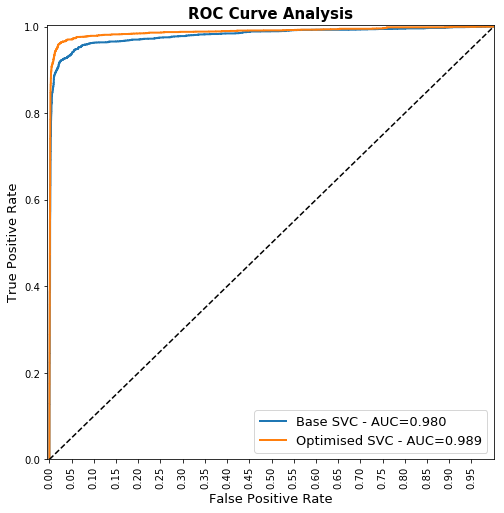

In [73]:
from sklearn.metrics import roc_curve, auc

y_scores_base = model.decision_function(x_test)
y_scores_opt = searchcv.decision_function(x_test)

fpr_base, tpr_base, auc_thresholds_base = roc_curve(y_test, y_scores_base)
fpr_bayesian, tpr_bayesian, auc_thresholds = roc_curve(y_test, y_scores_opt)
print(f'Base model AUC: {auc(fpr_base, tpr_base)}\nOptimised model AUC: {auc(fpr_bayesian, tpr_bayesian)}')

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

plt.show()

The 1st experiment for feature selection will use Chi-Squared analysis of the feature set, to select a specified number of features that have the highest correlation with the class set:

![title](img/ChiSquared.png)<br/><br/>

For a base test, we will select the top 5 features from the dataset:

In [52]:
chi_selector = SelectKBest(chi2, k=5)
chi_fit = chi_selector.fit(x, y)

np.set_printoptions(precision=4, suppress=True)
i = 0
for col in x.columns:
    print("{} - {:.3f}".format(col, chi_fit.scores_[i]))
    i+=1

chi_x = chi_fit.transform(x)
display(chi_x)

URLLength - 78915.344
HostLength - 1684.745
TLDLength - 595.874
DotCount - 445.415
DashCount - 52358.421
@Count - 41.561
%Count - 13135.528
=Count - 913.961
?Count - 35.067
DigitCount - 559.712
UniqueCharCount - 4680.189


array([[ 74,  14,   0,   0,  24],
       [106,  12,   9,   0,  32],
       [ 95,  15,   3,   0,  29],
       ...,
       [ 84,   6,   2,   0,  19],
       [127,  11,  17,   0,  33],
       [ 84,  15,   5,   0,  22]])

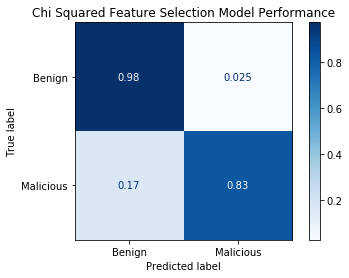

In [54]:
X_train_chi, x_test_chi, Y_train_chi, y_test_chi = train_test_split(chi_x, y, test_size = 0.33, random_state = 42)

chi_scaler=LexicalFeatureScaler()
chi_scaler.fit(X_train_chi, Y_train_chi)
X_train_chi = chi_scaler.transform(X_train_chi)
x_test_chi = chi_scaler.transform(x_test_chi)

chi_base_model = SVC()
chi_base_model.fit(X_train_chi, Y_train_chi)
y_pred_chi = chi_base_model.predict(x_test_chi)

disp = plot_confusion_matrix(chi_base_model, x_test_chi, y_test_chi,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Chi Squared Feature Selection Model Performance')
plt.show()

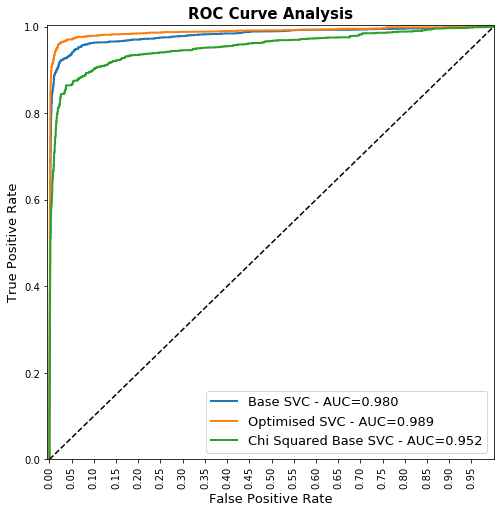

In [75]:
y_scores_chi = chi_base_model.decision_function(x_test_chi)

fpr_chi, tpr_chi, auc_thresholds_chi = roc_curve(y_test_chi, y_scores_chi)

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot(fpr_chi, tpr_chi, linewidth=2, label="Chi Squared Base {} - AUC={:.3f}".format(chi_base_model.__class__.__name__, auc(fpr_chi, tpr_chi)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

In [58]:
chi_searchcv = BayesSearchCV(
    SVC(),
    search_spaces = {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'kernel': Categorical(['poly', 'rbf']),
    },
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

start_time = time.time()
chi_searchcv.fit(X_train_chi, Y_train_chi, callback=on_step)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   35.0s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   46.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   37.4s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   46.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   32.2s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   34.6s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   48.7s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   37.0s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   46.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   56.8s remaining:   37.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.9s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   46.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   29.0s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.4s finished


Best score: 0.9751685107465344
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.7s finished


Best score: 0.9751685107465344


BayesSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
              error_score='raise',
              estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='scale', kernel='rbf', max_iter=-1,
                            probability=False, random_state=None,
                            shrinking=True, tol=0.001, verbose=False),
              fit_params=None, iid=True, n_iter=...,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='identity'),
                             'gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='identity'),
                             'kernel': Categorical(categories=('poly', 'rbf'

In [59]:
import json
import collections
import scipy

def isnamedtuple(obj):
    """Heuristic check if an object is a namedtuple."""
    return isinstance(obj, tuple) \
           and hasattr(obj, "_fields") \
           and hasattr(obj, "_asdict") \
           and callable(obj._asdict)
        
def serialize(data):
    if data is None or isinstance(data, (bool, int, float, str)):
        return data
    if isinstance(data, list):
        return [serialize(val) for val in data]
    if isinstance(data, collections.OrderedDict):
        return {"py/collections.OrderedDict":
                [[serialize(k), serialize(v)] for k, v in data.iteritems()]}
    if isnamedtuple(data):
        return {"py/collections.namedtuple": {
            "type":   type(data).__name__,
            "fields": list(data._fields),
            "values": [serialize(getattr(data, f)) for f in data._fields]}}
    if isinstance(data, dict):
        if all(isinstance(k, str) for k in data):
            return {k: serialize(v) for k, v in data.items()}
        return {"py/dict": [[serialize(k), serialize(v)] for k, v in data.items()]}
    if isinstance(data, tuple):
        return {"py/tuple": [serialize(val) for val in data]}
    if isinstance(data, set):
        return {"py/set": [serialize(val) for val in data]}
    if isinstance(data, np.ndarray):
        return {"py/numpy.ndarray": {
            "values": data.tolist(),
            "dtype":  str(data.dtype)}}
    if isinstance(data, scipy.sparse.csr.csr_matrix):
        data = data.toarray()
        return {"py/scipy.csr_matrix": {
            "values": data.tolist(),
            "dtype":  str(data.dtype)}}
    if isinstance(data, OneHotEncoder):
        return
    raise TypeError("Type %s not data-serializable" % type(data))
    
    
def restore(dct):
    if "py/dict" in dct:
        return dict(dct["py/dict"])
    if "py/tuple" in dct:
        return tuple(dct["py/tuple"])
    if "py/set" in dct:
        return set(dct["py/set"])
    if "py/collections.namedtuple" in dct:
        data = dct["py/collections.namedtuple"]
        return namedtuple(data["type"], data["fields"])(*data["values"])
    if "py/numpy.ndarray" in dct:
        data = dct["py/numpy.ndarray"]
        return np.array(data["values"], dtype=data["dtype"])
    if "py/collections.OrderedDict" in dct:
        return OrderedDict(dct["py/collections.OrderedDict"])
    if "py/scipy.csr_matrix" in dct:
        data = dct["py/scipy.csr_matrix"]
        arr =  np.array(data["values"], dtype=data["dtype"])
        return sparse.csr_matrix(arr)
    if "py/sklearn.preprocessing._encoders.OneHotEncoder" in dct:
        attr = dct["py/sklearn.preprocessing._encoders.OneHotEncoder"]
        return deserialize(SVC(), attr)
    return dct
    
def data_to_json(data, location):
    attr_json = serialize(data)
    with open(location, "w") as write_file:
        json.dump(attr_json, write_file)
    return json.dumps(attr_json, indent=4)

def json_to_data(s, file):
    with open(file, "r") as read_file:
        attr_data = json.load(read_file, object_hook=restore)
        return attr_data

def deserialize(estim, attr):
    for k, v in attr.items():
        setattr(estim, k, v)
    return estim

In [69]:
y_pred_bayesian_chi = chi_searchcv.predict(x_test_chi)
print(f'TPR: {tpr(y_test_chi, y_pred_bayesian_chi)}\nTNR: {tnr(y_test_chi, y_pred_bayesian_chi)}\nFPR: {fpr(y_test_chi, y_pred_bayesian_chi)}\nFNR: {fnr(y_test_chi, y_pred_bayesian_chi)}')
print(f'Best params found: {chi_searchcv.best_params_}')

chi_bayesian_model_loc='/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/chi_bayesian_svc_model.json'
data_to_json(chi_searchcv.best_estimator_.__dict__, chi_bayesian_model_loc)

TPR: 0.7727392565251779
TNR: 0.9399948713565262
FPR: 0.0600051286434738
FNR: 0.22726074347482203
Best params found: {'C': 4.432180887313634, 'gamma': 0.931185333062054, 'kernel': 'rbf'}


'{\n    "decision_function_shape": "ovr",\n    "break_ties": false,\n    "kernel": "rbf",\n    "degree": 3,\n    "gamma": 0.931185333062054,\n    "coef0": 0.0,\n    "tol": 0.001,\n    "C": 4.432180887313634,\n    "nu": 0.0,\n    "epsilon": 0.0,\n    "shrinking": true,\n    "probability": false,\n    "cache_size": 200,\n    "class_weight": null,\n    "verbose": false,\n    "max_iter": -1,\n    "random_state": null,\n    "_sparse": false,\n    "class_weight_": {\n        "py/numpy.ndarray": {\n            "values": [\n                1.0,\n                1.0\n            ],\n            "dtype": "float64"\n        }\n    },\n    "classes_": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1\n            ],\n            "dtype": "int64"\n        }\n    },\n    "_gamma": 0.931185333062054,\n    "support_": {\n        "py/numpy.ndarray": {\n            "values": [\n                7,\n                21,\n                23,\n                47

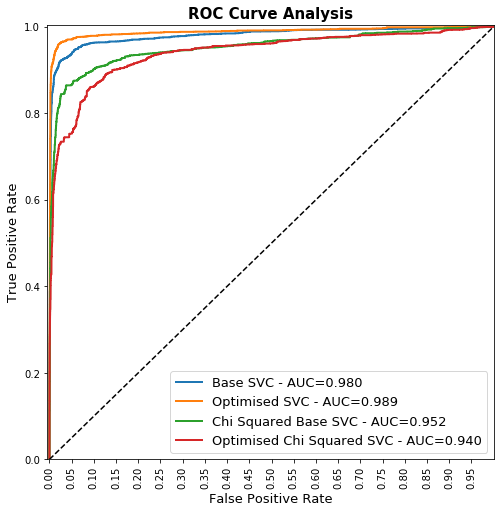

In [77]:
y_scores_bayesian_chi = chi_searchcv.best_estimator_.decision_function(x_test_chi)

fpr_bayesian_chi, tpr_bayesian_chi, auc_thresholds_bayesian_chi = roc_curve(y_test_chi, y_scores_bayesian_chi)

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot(fpr_chi, tpr_chi, linewidth=2, label="Chi Squared Base {} - AUC={:.3f}".format(chi_base_model.__class__.__name__, auc(fpr_chi, tpr_chi)))
plt.plot(fpr_bayesian_chi, tpr_bayesian_chi, linewidth=2, label="Optimised Chi Squared {} - AUC={:.3f}".format(chi_searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian_chi, tpr_bayesian_chi)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

It can be observed from the plot above that whenever the Chi Squared statistical analysis is applied to the dataset, and the top 5 features are selected:<br/>
- Increase in model prediction accuracy for a default SVM classifier
- Improved AUC for Receiver Operating Characteristic (ROC)

In [2]:
from sklearn.neighbors import KNeighborsClassifier

X_numpy=features_df.to_numpy()
X_train_knn=X_numpy[100:, [0, -2]]

Y_numpy=features_df['URLType'].to_numpy()
Y_train_knn = Y_numpy[100:]
display(X_train_knn)

h = .02 # step size in the mesh

knn=KNeighborsClassifier()

# we create an instance of Neighbours Classifier and fit the data.
knn.fit(X_train_knn, Y_train_knn)

# Plot the decision boundary. For that, we will asign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train_knn[:,0].min() - .5, X_train_knn[:,0].max() + .5
y_min, y_max = X_train_knn[:,1].min() - .5, X_train_knn[:,1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(9, 9))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Plot also the training points
plt.scatter(X_train_knn[:,0], X_train_knn[:,1],c=Y_train_knn )
plt.xlabel('URL Length')
plt.ylabel('Unique Char Count')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

NameError: name 'features_df' is not defined